In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
np.random.seed(0)
X = np.random.rand(100, 1)
y = 3 * X + 2 + np.random.randn(100, 1) * 0.1

# Split the data into training and testing sets
X_train, y_train = X[:80], y[:80]
X_test, y_test = X[80:], y[80:]

# Define the placeholders for input and output
X_placeholder = tf.placeholder(tf.float32, shape=(None, 1))
y_placeholder = tf.placeholder(tf.float32, shape=(None, 1))

# Define the variables for the slope and intercept
W = tf.Variable(tf.random.normal((1, 1)))
b = tf.Variable(tf.random.normal((1,)))

# Define the linear regression model
y_pred = tf.matmul(X_placeholder, W) + b

# Define the loss function (mean squared error)
loss = tf.reduce_mean(tf.square(y_pred - y_placeholder))

# Define the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(loss)

# Initialize the variables
init = tf.global_variables_initializer()

# Start a TensorFlow session
with tf.Session() as sess:
    sess.run(init)

    # Training loop
    for epoch in range(100):
        _, current_loss = sess.run([train_op, loss], feed_dict={X_placeholder: X_train, y_placeholder: y_train})
        if epoch % 10 == 0:
            print("Epoch:", epoch, "Loss:", current_loss)

    # Make predictions on the test set
    y_pred_test = sess.run(y_pred, feed_dict={X_placeholder: X_test})

# Plot the results
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, label="Test data")
plt.plot(X_test, y_pred_test, color='red', label="Predictions")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 6.3701
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 1.8471
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 0.5843
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2273
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1247
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0925
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0801
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0734
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0685
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0645
Epoch 11/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0608
Epoch 12/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0574
Epoch 13/100
25/25 [=================

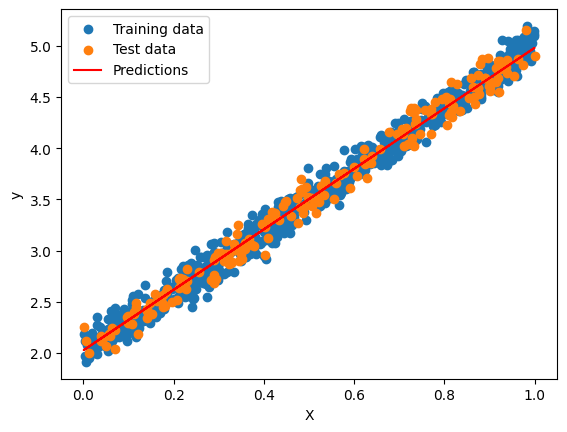

In [4]:
import tensorflow as tf
import numpy as np

# Generate some random data
np.random.seed(0)
X = np.random.rand(1000, 1)
y = 3 * X + 2 + np.random.randn(1000, 1) * 0.1

# Split the data into training and testing sets
x_train, y_train = X[:800], y[:800]
x_test, y_test = X[800:], y[800:]

# Define the linear regression model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1])
])

# Compile the model
model.compile(optimizer='sgd', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=100)

# Make predictions
predictions = model.predict(x_test)

# Plot the results
plt.scatter(x_train, y_train, label="Training data")
plt.scatter(x_test, y_test, label="Test data")
plt.plot(x_test, predictions, color='red', label="Predictions")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


ソースコード4.9　必要なパッケージインポート

In [ ]:
import os.path
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook, tqdm

from IPython.core.display import display

tf.set_random_seed(123456789)
np.random.seed(123456789)

%matplotlib inline

sns.set()
sns.set_style('white')
plt.rcParams['font.family'] = 'Yu Mincho'

# C:\\sample\\nn_linear_regression にデータを読み書きする
WORK_DIR = os.path.join('C:\\', 'sample', 'nn_linear_regression') 

ソースコード4.10　回帰分析で準備したデータの読み込み

In [ ]:
print('データ読み込み開始')
data_for_analysis = pd.read_pickle(
    os.path.join(WORK_DIR, 'data_for_analysis_fin.pickle')
)
print('データ読み込み終了')

ソースコード4.11　データ欠損の範囲調査

In [ ]:
np.isnan(data_for_analysis.select_dtypes(include=[np.number])).sum(axis=0)

ソースコード4.12　欠損しているデータの除外

In [ ]:
input_columns = [
    'market_beta', '企業規模', '簿価時価比率', '財務レバレッジ',
    'PER', '赤字ダミー', '25日移動平均乖離率'
]

# 使用するカラムに絞る
data_reduced = data_for_analysis.loc[:, ['超過収益率', *input_columns]]

# 欠損レコードの削除
data_reduced_wo_nan = data_reduced.dropna()

print(f'欠損を除く前のレコード数: {data_reduced.shape[0]}')

print(f'欠損を除いた後のレコード数: {data_reduced_wo_nan.shape[0]}')

# 超過収益率（当日）を抽出
data_labels = data_reduced_wo_nan.loc[:, '超過収益率'].to_frame().rename(
    columns={'超過収益率': '翌日超過収益率'}
)

# 超過収益率（当日）を1 日ズラし、入力値と合わせる
data_shifted = data_reduced_wo_nan.join(
    data_labels.groupby(level=0).shift(-1)
).dropna() 

print(
    f'欠損を除いて翌日超過収益率カラムを追加した後のレコード数：'
    f'{data_shifted.shape[0]}'
)

* ソースコード4.13　ネットワークの構築（SimpleNeuralNetworkクラスから抜粋）
* ソースコード4.14　 ニューラルネットワークの学習メソッドとウェイト保存メソッド（SimpleNeuralNetworkクラスから抜粋）
* ソースコード4.20　 ニューラルネットワークの予測値を算出するメソッド（SimpleNeuralNetworkクラスから抜粋）

In [ ]:
# -- ソースコード4.13 ---
class SimpleNeuralNet:
    def __init__(self, sess, num_columns, training=True):
        with tf.variable_scope('simple_neuralnet'):
            self.inputs = tf.placeholder(
                tf.float32, [num_columns], name='inputs'
            )
            self.inputs_reshaped = tf.reshape(
                self.inputs, [1, num_columns]
            )
            
            self.label = tf.placeholder(tf.float32, [1], name='label')
            self.label_reshaped = tf.reshape(self.label, [1, 1])
            
            self.l1_w = tf.get_variable(
                'l1_w', [num_columns, 1], dtype=tf.float32
            )
            self.l1_b = tf.get_variable(
                'l1_b', [1], dtype=tf.float32
            )
            
            # @ == matrix multiplication PEP465
            self.output = self.inputs_reshaped @ self.l1_w + self.l1_b
             
            self.loss = tf.losses.mean_squared_error(
                self.label_reshaped, self.output
            )
            
            self.train_step = tf.train.AdagradOptimizer(0.1).minimize(
                self.loss
            )
        
        
        if training: # ここは学習時のみ実行
            sess.run(tf.global_variables_initializer())
        
        self.saver = tf.train.Saver(
            var_list=tf.get_collection(
                tf.GraphKeys.GLOBAL_VARIABLES, scope='simple_neuralnet'
            )
        )
# -- ソースコード4.13 ここまで ---

# -- ソースコード4.14 ---
    def train_one_step(self, sess, inputs, label):
        feed_dict = {
            self.inputs: inputs,
            self.label: label
        }
        fetches = [
            self.loss,
            self.train_step
        ]
        return sess.run(fetches, feed_dict)
    
    def save(self, sess, path):
        self.saver.save(sess, path)
        print(f'ウェイトを{path}に保存しました。')
# -- ソースコード4.14 ここまで ---

# -- ソースコード4.20 ---
    def predict(self, sess, inputs):
        feed_dict = {
            self.inputs: inputs
        }
        fetches = [
            self.output
        ]
        return sess.run(fetches, feed_dict)
# -- ソースコード4.20 ここまで ---
    
    def get_l1(self, sess):
        feed_dict = {
        }
        fetches = [
            self.l1_w,
            self.l1_b
        ]
        return sess.run(fetches, feed_dict)
    

    def restore(self, sess, path):
        self.saver.restore(sess, path)
        print(f'model restored from {path}')

ソースコード4.15　準備したデータと学習メソッドを使用したウェイトの学習

In [ ]:
max_train_steps = 20000
polling_interval = 100

# 入力データと期待出力データに分ける
data_inputs = data_shifted.loc[:, input_columns] 
# 期待出力データ
data_labels = data_shifted.loc[:, ['翌日超過収益率']] 

# エポックごとの損失を保存する配列を予め準備
loss_over_time = np.empty(
    max_train_steps // polling_interval
)

# エポックごとのウェイトを保存する配列を予め準備
weights_over_time = np.empty(
    (max_train_steps // polling_interval, len(input_columns) + 1)
)

# グラフを初期化
tf.reset_default_graph()

with tf.Graph().as_default() and tf.Session() as session:
    simple_neural_net = SimpleNeuralNet(
        session,
        len(input_columns),
        training=True
    )
    
    train_step = 0
    loss_mean_polling_interval = 0.
    for random_row in np.random.choice(
        data_inputs.shape[0] - 1,
        max_train_steps, 
        replace=True
    ):
        current_loss, _ = simple_neural_net.train_one_step(
            session,
            data_inputs.iloc[random_row, :].values,
            data_labels.iloc[random_row, :].values
        )
        
        loss_mean_polling_interval += current_loss

        train_step += 1
        if train_step % polling_interval == 0:
            loss_over_time[
                train_step // polling_interval - 1
            ] = loss_mean_polling_interval / polling_interval
            
            loss_mean_polling_interval = 0.
            
            l1_w, l1_b = simple_neural_net.get_l1(session)
            
            weights_over_time[
                train_step // polling_interval - 1
            ] = np.array([l1_b, *l1_w]).flatten()
            
            print(
                f'[{(train_step * 100) // max_train_steps:3}%] '
                f'直近{polling_interval}ステップの平均ロス：'
                f'{loss_over_time[train_step // polling_interval - 1]:.5f}'
            )
        
    simple_neural_net.save(
        session, os.path.join(
            WORK_DIR, 'models', 'simple_neural_nets', 'simple_neural_net'
        )
    )
    

ソースコード4.16　ニューラルネットワークのウェイト時系列を使いやすい形状に変換

In [ ]:
weights_over_time_df = pd.DataFrame(
    weights_over_time,
    columns=['alpha', *input_columns])
weights_over_time_tidy = weights_over_time_df.stack().reset_index()
weights_over_time_tidy.columns = ['エポック＃', '説明変数', 'ウェイト']

Ìソースコード4.17　学習時のウェイトの時系列プロット

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(
    data=weights_over_time_tidy,
    x='エポック＃',
    y='ウェイト',
    hue='説明変数'
)
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles[1:], labels=labels[1:],
    loc=4, ncol=3, title=labels[0]
)

ソースコード4.18　学習時の（対数）ロスの時系列プロット

In [ ]:
loss_over_time_df = pd.DataFrame(
    loss_over_time,
    columns=['loss']).reset_index()
loss_over_time_df.columns = ['エポック＃', 'ロス']

sns.lineplot(
    x='エポック＃',
    y='ロス',
    data=loss_over_time_df,
    ax=ax
).set(
    yscale='log',
    ylabel='ロス（対数スケール）'
)
#fig.savefig(WORK_DIR + '/picture/4章_図4-10.eps')

ソースコード4.19　最後の50回の学習エポックのウェイトのまとめ

In [ ]:
weights_over_time_df.assign().tail(1000).describe().transpose()

ソースコード4.21　翌日超過収益率の予測値の計算

In [ ]:
predicted_returns = np.empty(data_shifted.shape[0])

tf.reset_default_graph()
with tf.Graph().as_default() and tf.Session() as session:
    simple_neural_net = SimpleNeuralNet(session, len(input_columns), training=False)
    simple_neural_net.restore(
        session,
        os.path.join(
            WORK_DIR, 'models', 'simple_neural_nets', 'simple_neural_net'
        )
    )
    for row_i, row in tqdm(
        enumerate(data_shifted.loc[:, input_columns].itertuples(index=False)),
        total=data_shifted.shape[0],
        miniters=data_shifted.shape[0]//100
    ):
        # print(np.array(row))
        predicted_returns[row_i] = simple_neural_net.predict(session, row)[0]

data_shifted = data_shifted.assign(**{'翌日超過収益率（NN予測）': predicted_returns})

ソースコード4.22　 予測値を使ったポートフォリオとマーケット平均ポートフォリオの収益率の計算

In [ ]:
unique_dates = data_shifted.index.get_level_values(1).unique()

lower_quantile_returns = np.empty(len(unique_dates))
upper_quantile_returns = np.empty(len(unique_dates))
mean_portfolio_returns = np.empty(len(unique_dates))

for i, cur_date in enumerate(unique_dates):
    # 日付ごとのデータを取り出す
    cur_date_rows = data_shifted.loc[
        data_shifted.index.get_level_values(1) == cur_date
    ]
    
    lower_quantile = cur_date_rows.loc[
        :, '翌日超過収益率（NN予測）'
    ].quantile(0.2)
    
    upper_quantile = cur_date_rows.loc[
        :, '翌日超過収益率（NN予測）'
    ].quantile(0.8)
    
    lower_quantile_rows = cur_date_rows.loc[
        cur_date_rows.loc[:, '翌日超過収益率（NN予測）'] <= lower_quantile
    ]
    upper_quantile_rows = cur_date_rows.loc[
        cur_date_rows.loc[:, '翌日超過収益率（NN予測）'] >= upper_quantile
    ]
    
    lower_quantile_returns[i] = lower_quantile_rows.loc[
        :, '翌日超過収益率'
    ].mean()
    
    upper_quantile_returns[i] = upper_quantile_rows.loc[
        :, '翌日超過収益率'
    ].mean()
    
    mean_portfolio_returns[i] = cur_date_rows.loc[
        :, '翌日超過収益率'
    ].mean()

ソースコード4.23　ポートフォリオ価値の計算とそのグラフ化

In [ ]:
portfolio_returns = pd.DataFrame(
    np.transpose(
        [
            lower_quantile_returns,
            upper_quantile_returns,
            mean_portfolio_returns
        ]
    ),
    columns=['予測値下位20%', '予測値上位20%', 'マーケット平均'],
    index=unique_dates
).stack().to_frame()
portfolio_returns.columns = ['翌日超過収益率']
portfolio_returns.index = portfolio_returns.index.rename(
    ['日時', 'ポートフォリオ']
)

portfolio_returns = portfolio_returns.assign(
    ポートフォリオ価値=(portfolio_returns + 1.).groupby(level=1).cumprod()
)

_, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(
    data=portfolio_returns.reset_index(),
    x='日時',
    y='ポートフォリオ価値',
    hue='ポートフォリオ',
    ax=ax
)